
Introduction:

The city of New York, is the most populous city in the United States. With an estimated 2018 population of 8,398,748 distributed over about 302.6 square miles (784 km2), New York city, is also the most densely populated major city in the United States. 

It is the largest metropolitan area in the world by urban landmass.With almost 20 million people in its metropolitan statistical area and approximately 23 million in its combined statistical area, it is one of the world's most populous megacities. 

Situated on one of the world's largest natural harbors, New York City is divided into five administrative boroughs, each of which is a separate county of the State of New York.The five boroughs – Brooklyn, Queens, Manhattan, The Bronx, and Staten Island – were consolidated into a single city in 1898.

As many as 800 languages are spoken in New York city, making it the most linguistically diverse city in the world. 

The cuisine of New York City comprises many cuisines belonging to various ethnic groups that have entered the United States through the city, italian, french, chinese, etc. 

What about portuguese food? As part of this project, i will list and visualize all major parts of New York city, that has great portuguese resturants.

Note: For more about Portugal go to : https://www.visitportugal.com/pt-pt

Data:
    
1. New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude. 
   Data source : https://cocl.us/new_york_dataset Description : This data set contains the required information. 
   And we will use this data set to explore various neighborhoods of new york city. Portuguese resturants in each neighborhood of New york city. Data source : Fousquare API Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only portuguese resturants. GeoSpace data Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm Description : By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.

Approach:
    
1.Collect the new york city data from https://cocl.us/new_york_dataset
2.Using FourSquare API we will find all venues for each neighborhood.
3.Filter out all venues that are Portuguese Resturants.
4.Find rating , tips and like count for each Portuguese Resturants using FourSquare API.
5.Using rating for each resturant , we will sort that data.
6.Visualize the Ranking of neighborhoods using folium library(python)

Queries that can be answered using above dataset:

1.What is best location in New York City for portuguese cuisine ?
2.Which areas have potential for opening a resturant ?
3.Which all areas lack a portuguese resturant ?
4.Which is the best place to stay if i want to try Portuguese cuisine ?

Analysis
Required Libraries
pandas and numpy for handling data.
request module for using FourSquare API.
geopy to get co-ordinates of City of New York.
folium to visualize the results on a map

In [1]:
! pip install geocoder
! pip install folium
! pip install geopy

     |████████████████████████████████| 102kB 11.4MB/s ta 0:00:01
     |████████████████████████████████| 92kB 6.4MB/s eta 0:00:011


In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
import sys
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


My variables

In [3]:
    CLIENT_ID = 'OUKTHJYZFXA0ZPMS0JWRR1BGTQKN04NBYGLSSL5CW11NE0RP' # changed my Foursquare ID
    CLIENT_SECRET = 'TO0NBMZBGLTCNCVE1KBHAZWKMPPZD14DDXHRNOAYYVITIB0V' # changed Foursquare Secret
    VERSION = '20180605' # Foursquare API version

Now we define a function to get the geocodes i.e latitude and longitude of a given location using geopy.

In [4]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

We define a function to intract with FourSquare API and get top 50 venues within a radius of 10000 metres for a given latitude and longitude. Below function will return us the venue id , venue name and category.

In [5]:
def get_venues(lat,lng):
    #set variables
    radius=10000
    LIMIT=50
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


In [6]:
def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Now we define a funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.

In [7]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)  
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

We will call the above funtion to get the new york city data.

In [8]:
# get new york data
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
new_york_data.shape

(306, 4)

There are 306 neighborhoods in New York city!

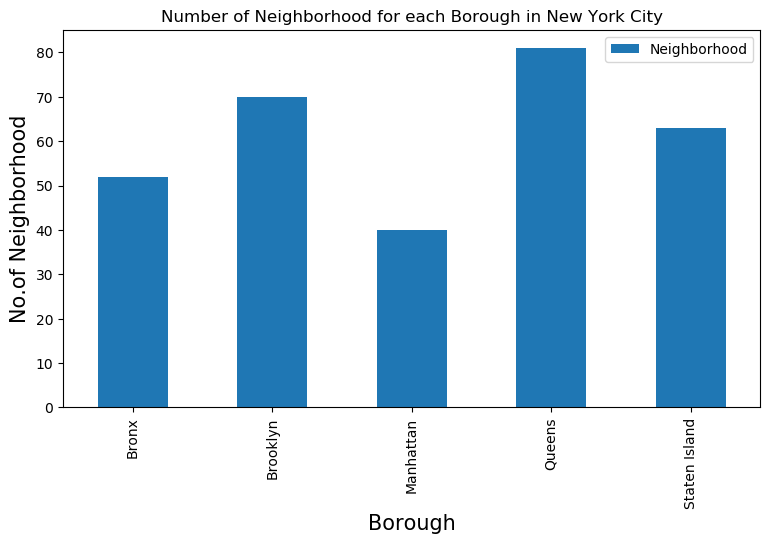

In [10]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We see that Queens has highest number of neighborhoods

Now we will collect Portuguese resturants for each Neighborhood

In [11]:
# prepare neighborhood list that contains portuguese resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
Portuguese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    Portuguese_resturants=venues[venues['Category']=='Portuguese Restaurant']   
    print('(',count,'/',len(new_york_data),')','Portuguese resturants in '+Neighborhood+', '+Borough+':'+str(len(Portuguese_resturants)))
    print(row)
    for resturant_detail in Portuguese_resturants.values.tolist():
        id, name , category=resturant_detail
        Portuguese_rest_ny = Portuguese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Portuguese resturants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Portuguese resturants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Portuguese resturants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Portuguese resturants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Portuguese resturants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Portuguese resturants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Portuguese resturants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Portuguese resturants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Portuguese resturants in N

In [12]:
# Save the information so far to a .csv file due to limited calls on FourSquare
Portuguese_rest_ny.to_csv('Portuguese_rest_ny_tocsv1.csv')

In [13]:
Portuguese_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Queens,Glendale,4c0abd813c70b7132e0d285b,O Lavrador
1,Queens,South Ozone Park,4c0abd813c70b7132e0d285b,O Lavrador
2,Queens,Jamaica Center,4c0abd813c70b7132e0d285b,O Lavrador
3,Queens,Hollis,4c0abd813c70b7132e0d285b,O Lavrador
4,Queens,South Jamaica,4c0abd813c70b7132e0d285b,O Lavrador


In [14]:
Portuguese_rest_ny.shape

(22, 4)

We got 23 Portuguese resturant across New York City!

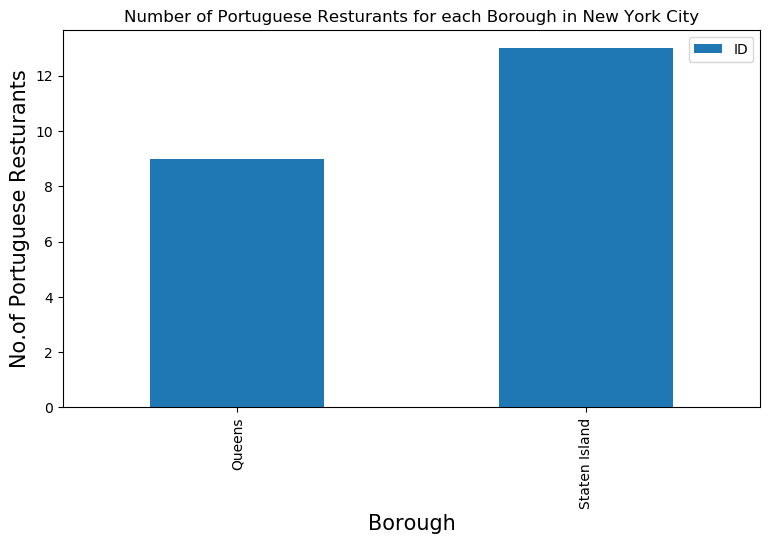

In [15]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Portuguese Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Portuguese Resturants', fontsize=15)
#giving a bar plot
Portuguese_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

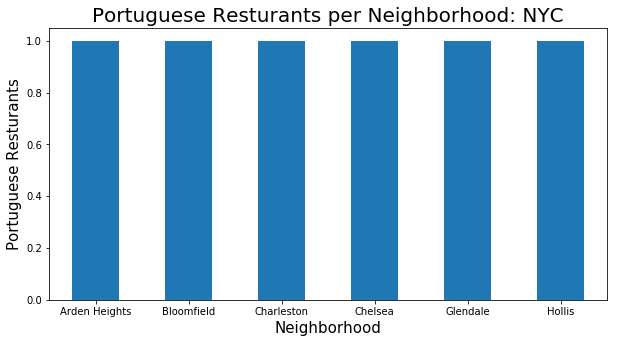

In [16]:
NOofNeigh = 6 # top number for graphing all the same past 6
Portuguese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5))
plt.title('Portuguese Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Portuguese Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

In [17]:
Portuguese_rest_ny[Portuguese_rest_ny['Neighborhood']=='Arden Heights']

,Borough,Neighborhood,ID,Name
15,Staten Island,Arden Heights,4cd6f3a1122ba143eac635a1,Chateau Madrid


In [18]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
Portuguese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in Portuguese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details= get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(Portuguese_rest_ny),')','processed')
    Portuguese_rest_stats_ny = Portuguese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
Portuguese_rest_stats_ny.tail()


{'meta': {'code': 200, 'requestId': '5e72bb2cda9e1400225c994b'}, 'response': {'venue': {'id': '4c0abd813c70b7132e0d285b', 'name': 'O Lavrador', 'contact': {'phone': '7185261526', 'formattedPhone': '(718) 526-1526'}, 'location': {'address': '13840 101st Ave', 'lat': 40.69451226698791, 'lng': -73.80954400032125, 'labeledLatLngs': [{'label': 'display', 'lat': 40.69451226698791, 'lng': -73.80954400032125}], 'postalCode': '11435', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['13840 101st Ave', 'Jamaica, NY 11435', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/o-lavrador/4c0abd813c70b7132e0d285b', 'categories': [{'id': '4def73e84765ae376e57713a', 'name': 'Portuguese Restaurant', 'pluralName': 'Portuguese Restaurants', 'shortName': 'Portuguese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/portuguese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d150941735', 'name': 'Spanish Restaurant', 'plura

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
17,Staten Island,Bloomfield,4cd6f3a1122ba143eac635a1,Chateau Madrid,27,8.4,12
18,Staten Island,Howland Hook,4ba14cc2f964a5206faa37e3,Valenca Restaurant,178,8.7,71
19,Staten Island,Sandy Ground,4cd6f3a1122ba143eac635a1,Chateau Madrid,27,8.4,12
20,Staten Island,Prince's Bay,4cd6f3a1122ba143eac635a1,Chateau Madrid,27,8.4,12
21,Staten Island,Richmond Valley,4cd6f3a1122ba143eac635a1,Chateau Madrid,27,8.4,12


In [19]:
# I continue to save data to a .csv as I move through this project
Portuguese_rest_stats_ny.to_csv('Portuguese_rest_stats_ny_csv.csv')

In [20]:
Portuguese_rest_stats_ny.shape

(22, 7)

In [21]:
Portuguese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 7 columns):
Borough         22 non-null object
Neighborhood    22 non-null object
ID              22 non-null object
Name            22 non-null object
Likes           22 non-null object
Rating          22 non-null float64
Tips            22 non-null object
dtypes: float64(1), object(6)
memory usage: 1.3+ KB


In [22]:
Portuguese_rest_stats_ny['Likes']=Portuguese_rest_stats_ny['Likes'].astype('float64')

In [23]:
Portuguese_rest_stats_ny['Tips']=Portuguese_rest_stats_ny['Tips'].astype('float64')

In [24]:
Portuguese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 7 columns):
Borough         22 non-null object
Neighborhood    22 non-null object
ID              22 non-null object
Name            22 non-null object
Likes           22 non-null float64
Rating          22 non-null float64
Tips            22 non-null float64
dtypes: float64(3), object(4)
memory usage: 1.3+ KB


In [25]:
Portuguese_rest_stats_ny.describe()

,Likes,Rating,Tips
count,22.000000,22.000000,22.00000
mean,50.954545,8.427273,19.00000
std,42.874654,0.088273,16.94248
min,27.000000,8.400000,12.00000
25%,27.000000,8.400000,12.00000
50%,39.500000,8.400000,14.00000
75%,52.000000,8.400000,16.00000
max,178.000000,8.700000,71.00000


In [26]:
# Resturant with maximum Likes
Portuguese_rest_stats_ny.iloc[Portuguese_rest_stats_ny['Likes'].idxmax()]

Borough                    Staten Island
Neighborhood                  Port Ivory
ID              4ba14cc2f964a5206faa37e3
Name                  Valenca Restaurant
Likes                                178
Rating                               8.7
Tips                                  71
Name: 9, dtype: object

In [27]:
# Resturant with maximum Rating
Portuguese_rest_stats_ny.iloc[Portuguese_rest_stats_ny['Rating'].idxmax()]

Borough                    Staten Island
Neighborhood                  Port Ivory
ID              4ba14cc2f964a5206faa37e3
Name                  Valenca Restaurant
Likes                                178
Rating                               8.7
Tips                                  71
Name: 9, dtype: object

In [28]:
# Resturant with maximum Tips
Portuguese_rest_stats_ny.iloc[Portuguese_rest_stats_ny['Tips'].idxmax()]

Borough                    Staten Island
Neighborhood                  Port Ivory
ID              4ba14cc2f964a5206faa37e3
Name                  Valenca Restaurant
Likes                                178
Rating                               8.7
Tips                                  71
Name: 9, dtype: object

In [29]:
ny_neighborhood_stats=Portuguese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [30]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
6,Howland Hook,8.7
10,Port Ivory,8.7
0,Arden Heights,8.4
12,Richmond Valley,8.4
20,Travis,8.4
19,St. Albans,8.4
18,Springfield Gardens,8.4
17,South Ozone Park,8.4
16,South Jamaica,8.4
15,Sandy Ground,8.4


Above are the top neighborhoods with top average rating of Portuguese Restaurant

In [31]:
ny_borough_stats=Portuguese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [32]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
6,Howland Hook,8.7
10,Port Ivory,8.7
0,Arden Heights,8.4
12,Richmond Valley,8.4
20,Travis,8.4
19,St. Albans,8.4
18,Springfield Gardens,8.4
17,South Ozone Park,8.4
16,South Jamaica,8.4
15,Sandy Ground,8.4


Above are the top neighborhoods with top average rating of Portuguese resturant

In [33]:
ny_borough_stats=Portuguese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [34]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Staten Island,8.446154
0,Queens,8.400000


Similarly these are the average rating of Portuguese Resturants for each Borough

Lets visualize it

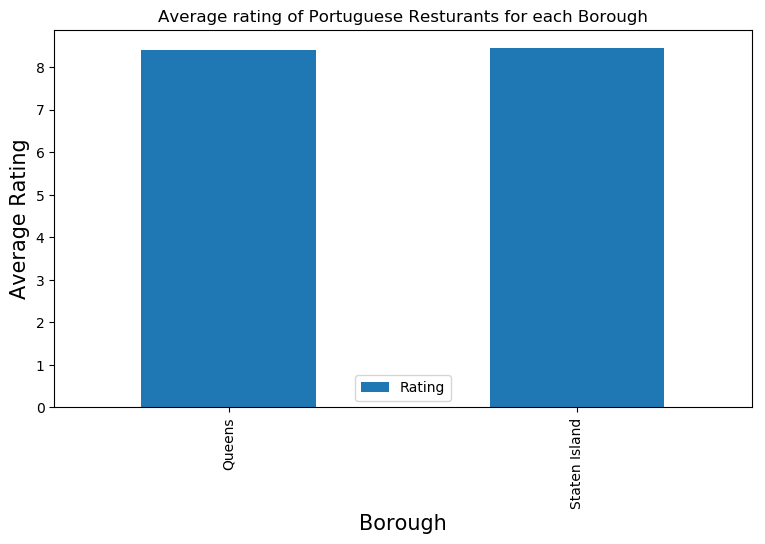

In [35]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Portuguese Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
Portuguese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will consider all the neighborhoods with average rating greater or equal 8 to visualize on map

In [36]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]

In [37]:
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Arden Heights,8.4
1,Bloomfield,8.4
2,Charleston,8.4
3,Chelsea,8.4
4,Glendale,8.4
5,Hollis,8.4
6,Howland Hook,8.7
7,Jamaica Center,8.4
8,Jamaica Estates,8.4
9,Pleasant Plains,8.4


We will join this dataset to original new york data to get lonitude and latitude

In [38]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [39]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [40]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Staten Island,Arden Heights,40.549286,-74.185887,8.4
1,Staten Island,Bloomfield,40.605779,-74.187256,8.4
2,Staten Island,Charleston,40.530531,-74.232158,8.4
3,Manhattan,Chelsea,40.744035,-74.003116,8.4
4,Staten Island,Chelsea,40.594726,-74.189560,8.4
5,Queens,Glendale,40.702762,-73.870742,8.4
6,Queens,Hollis,40.711243,-73.759250,8.4
7,Staten Island,Howland Hook,40.638433,-74.186223,8.7
8,Queens,Jamaica Center,40.704657,-73.796902,8.4
9,Queens,Jamaica Estates,40.716805,-73.787227,8.4


Now we will show this data on a map

In [41]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [42]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=30, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

Lets add a new field to dataframe for labeling purpose

In [43]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [44]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

Now that we have visualized the Neighborhoods. Lets Visualize Boroughs based on average Rating

In [45]:

ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

/opt/conda/envs/Python36/lib/python3.6/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


FileNotFoundError: [Errno 2] No such file or directory: 'Borough Boundaries.geojson'

In [ ]:
Conclusion
Arden(Staten Island), Bloomfield(Staten Island), are some of the best neighborhoods for Portuguese cuisine.
Manhattan have potential Portuguese Resturant Market
Quuens is the best place to stay if you prefer Quuens Cuisine.
Limitations
The ranking is purely on basis of rating of resturants
The accuracy of data depends purely depends on the data provided by FourSquare

### Limitations

The ranking is purely on basis of rating of resturants
The accuracy of data depends purely depends on the data provided by FourSquare